# Documentation

In [373]:
from IPython.core.display import HTML
HTML("""<style>
    .MathJax_Display { font-size: 23px; }
</style>""")

$$
\theta = \theta + \alpha (r + \gamma max_{a'} Q(s',a') - Q(s,a)) \nabla_{\theta} Q(s,a)
$$

# Setup

In [1]:
"""
Add parent directorys to current path
"""
import os.path
import sys


for p in ['..', '../..', '../../..', '../../../..']:
    d = os.path.abspath(p)
    if d not in sys.path:
        sys.path.insert(0,d)
    
"""
Add tiger-env directory to current path
Still not sure why this is needed.
"""
d = [os.path.abspath('../../../../../custom_envs/gym-tiger'),
    os.path.abspath('../../../../../custom_envs/gym-dummy/')]
for _d in d:
    if _d not in sys.path:
        sys.path.insert(0, _d)
    

"""
Enable hot-reloading
"""    
from notebook_utils import import_module_by_name, reload_module_by_name

def reload():
    reload_module_by_name('research.neural_networks.mlp', 'ReLU')
    reload_module_by_name('research.neural_networks.mlp', 'Sigmoid')
    reload_module_by_name('research.neural_networks.mlp', 'MLPRegressor')
    reload_module_by_name(
        'experiments.qlearning.dqn.single_obs_dqn.numpy_dqn_obs_single',
        'NumpyDQNObsSingle')
    global ReLU, Sigmoid, MLPRegressor
    global NumpyDQNObsSingle
    from research.neural_networks.mlp import ReLU, MLPRegressor
    from experiments.qlearning.dqn.single_obs_dqn.numpy_dqn_obs_single \
        import NumpyDQNObsSingle
    
    
import gym
import gym_tiger
import gym_dummy
import matplotlib.pyplot as plt
from tabulate import tabulate

from research.neural_networks.mlp import MLPRegressor, ReLU, Sigmoid
from experiments.qlearning.dqn.single_obs_dqn.numpy_dqn_obs_single \
        import NumpyDQNObsSingle, play_one, main, running_avg, plot_running_avg


OBS_GROWL_LEFT = [1, 0, 0]
OBS_GROWL_RIGHT = [0, 1, 0]
OBS_START = [0, 0, 1]

ACTION_OPEN_LEFT = 0
ACTION_OPEN_RIGHT = 1
ACTION_LISTEN = 2
ACTION_MAP = {
    ACTION_OPEN_LEFT: 'OPEN_LEFT',
    ACTION_OPEN_RIGHT: 'OPEN_RIGHT',
    ACTION_LISTEN: 'LISTEN',
}

# Tiger-v0 + Tensorflow

## Play 1000 Episodes with 100% observation accuracy

In [3]:
"""
Remove old tensorboard log files
"""
!rm -rf ./logs

import tensorflow as tf

env = gym.make('Tiger-v0')
env.__init__(reward_tiger=-100, reward_gold=10, reward_listen=-1,
            obs_accuracy=1)
gamma = 0.99
hidden_layer_sizes = [25, 25]
batch_size = 2
copy_period = 25
N=1000

session = tf.InteractiveSession()
D = env.observation_space.n
K = env.action_space.n
model = DQN('main', session, D, K, hidden_layer_sizes, gamma,
            batch_size=batch_size,
            log_summaries=True, logs_dir='./logs')
tmodel = DQN('target', session, D, K, hidden_layer_sizes, gamma,
             batch_size=batch_size)
init = tf.global_variables_initializer()
session.run(init)

totalrewards = np.zeros(N)
for n in range(N):
    eps = 1.0/np.sqrt(n+1)
#     eps = 1/(n+1)**(1/5)
    totalreward = play_one(env, model, tmodel, eps, gamma,
                           copy_period, max_steps=10)
    totalrewards[n] = totalreward
    if n % 100 == 0:
        ravg = running_avg(totalrewards, n)
        print('episode:', n,
              'total reward:', totalreward,
              'eps:', eps,
              'avg reward (last 100):', ravg)


print('avg reward for last 100 episodes:', totalrewards[-100:].mean())
print('total steps:', totalrewards.sum())

# plt.plot(totalrewards)
# plt.title("Rewards")
# plt.show()

# plot_running_avg(totalrewards)



"""
Inspect final Q values
"""
actions = model.predict([OBS_START,
                         OBS_GROWL_LEFT,
                         OBS_GROWL_RIGHT])
obs = np.array(['START', 'GROWL_LEFT', 'GROWL_RIGHT']).reshape(-1,1)
actions = np.hstack([obs, actions])
print(tabulate(actions, headers=list(ACTION_MAP.values())))

Instructions for updating:
Colocations handled automatically by placer.


/Users/jblandin/miniconda3/envs/research/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


episode: 0 total reward: -274 eps: 1.0 avg reward (last 100): -274.0
episode: 100 total reward: 1 eps: 0.09950371902099892 avg reward (last 100): -156.92079207920793
episode: 200 total reward: -10 eps: 0.07053456158585983 avg reward (last 100): -30.475247524752476
episode: 300 total reward: -10 eps: 0.0576390417704235 avg reward (last 100): -23.722772277227723
episode: 400 total reward: -10 eps: 0.04993761694389223 avg reward (last 100): -25.574257425742573
episode: 500 total reward: -109 eps: 0.04467670516087703 avg reward (last 100): -26.11881188118812
episode: 600 total reward: -10 eps: 0.04079085082240021 avg reward (last 100): -23.396039603960396
episode: 700 total reward: -10 eps: 0.0377694787300249 avg reward (last 100): -19.03960396039604
episode: 800 total reward: -10 eps: 0.03533326266687867 avg reward (last 100): -22.96039603960396
episode: 900 total reward: -10 eps: 0.03331483023263848 avg reward (last 100): -21.217821782178216
avg reward for last 100 episodes: -15.83
total

## Play 1000 Episodes with 92% observation accuracy

In [58]:
"""
Remove old tensorboard log files
"""
!rm -rf ./logs

import tensorflow as tf

env = gym.make('Tiger-v0')
env.__init__(reward_tiger=-100, reward_gold=10, reward_listen=-1,
            obs_accuracy=.92)
gamma = 0.99
hidden_layer_sizes = [25, 25]
batch_size = 2
copy_period = 25
N=1000

session = tf.InteractiveSession()
D = env.observation_space.n
K = env.action_space.n
model = DQN('main', session, D, K, hidden_layer_sizes, gamma,
            batch_size=batch_size,
            log_summaries=True, logs_dir='./logs')
tmodel = DQN('target', session, D, K, hidden_layer_sizes, gamma,
             batch_size=batch_size)
init = tf.global_variables_initializer()
session.run(init)

totalrewards = np.zeros(N)
for n in range(N):
    eps = 1.0/np.sqrt(n+1)
#     eps = 1/(n+1)**(1/5)
    totalreward = play_one(env, model, tmodel, eps, gamma,
                           copy_period, max_steps=10)
    totalrewards[n] = totalreward
    if n % 100 == 0:
        ravg = running_avg(totalrewards, n)
        print('episode:', n,
              'total reward:', totalreward,
              'eps:', eps,
              'avg reward (last 100):', ravg)


print('avg reward for last 100 episodes:', totalrewards[-100:].mean())
print('total steps:', totalrewards.sum())

# plt.plot(totalrewards)
# plt.title("Rewards")
# plt.show()

# plot_running_avg(totalrewards)



"""
Inspect final Q values
"""
actions = model.predict([OBS_START,
                         OBS_GROWL_LEFT,
                         OBS_GROWL_RIGHT])
obs = np.array(['START', 'GROWL_LEFT', 'GROWL_RIGHT']).reshape(-1,1)
actions = np.hstack([obs, actions])
print(tabulate(actions, headers=list(ACTION_MAP.values())))

episode: 0 total reward: 10 eps: 1.0 avg reward (last 100): 10.0
episode: 100 total reward: 10 eps: 0.09950371902099892 avg reward (last 100): -46.722772277227726
episode: 200 total reward: 10 eps: 0.07053456158585983 avg reward (last 100): -40.98019801980198
episode: 300 total reward: -100 eps: 0.0576390417704235 avg reward (last 100): -24.465346534653467
episode: 400 total reward: -10 eps: 0.04993761694389223 avg reward (last 100): -21.801980198019802
episode: 500 total reward: -10 eps: 0.04467670516087703 avg reward (last 100): -18.85148514851485
episode: 600 total reward: -10 eps: 0.04079085082240021 avg reward (last 100): -17.99009900990099
episode: 700 total reward: -10 eps: 0.0377694787300249 avg reward (last 100): -17.91089108910891
episode: 800 total reward: -10 eps: 0.03533326266687867 avg reward (last 100): -19.059405940594058
episode: 900 total reward: -10 eps: 0.03331483023263848 avg reward (last 100): -15.564356435643564
avg reward for last 100 episodes: -14.1
total steps

## Play 1000 Episodes with 85% observation accuracy

In [59]:
"""
Remove old tensorboard log files
"""
!rm -rf ./logs

import tensorflow as tf

env = gym.make('Tiger-v0')
env.__init__(reward_tiger=-100, reward_gold=10, reward_listen=-1,
            obs_accuracy=.85)
gamma = 0.99
hidden_layer_sizes = [25, 25]
batch_size = 2
copy_period = 25
N=1000

session = tf.InteractiveSession()
D = env.observation_space.n
K = env.action_space.n
model = DQN('main', session, D, K, hidden_layer_sizes, gamma,
            batch_size=batch_size,
            log_summaries=True, logs_dir='./logs')
tmodel = DQN('target', session, D, K, hidden_layer_sizes, gamma,
             batch_size=batch_size)
init = tf.global_variables_initializer()
session.run(init)

totalrewards = np.zeros(N)
for n in range(N):
    eps = 1.0/np.sqrt(n+1)
#     eps = 1/(n+1)**(1/5)
    totalreward = play_one(env, model, tmodel, eps, gamma,
                           copy_period, max_steps=10)
    totalrewards[n] = totalreward
    if n % 100 == 0:
        ravg = running_avg(totalrewards, n)
        print('episode:', n,
              'total reward:', totalreward,
              'eps:', eps,
              'avg reward (last 100):', ravg)


print('avg reward for last 100 episodes:', totalrewards[-100:].mean())
print('total steps:', totalrewards.sum())

# plt.plot(totalrewards)
# plt.title("Rewards")
# plt.show()

# plot_running_avg(totalrewards)



"""
Inspect final Q values
"""
actions = model.predict([OBS_START,
                         OBS_GROWL_LEFT,
                         OBS_GROWL_RIGHT])
obs = np.array(['START', 'GROWL_LEFT', 'GROWL_RIGHT']).reshape(-1,1)
actions = np.hstack([obs, actions])
print(tabulate(actions, headers=list(ACTION_MAP.values())))

episode: 0 total reward: 8 eps: 1.0 avg reward (last 100): 8.0
episode: 100 total reward: -100 eps: 0.09950371902099892 avg reward (last 100): -46.71287128712871
episode: 200 total reward: -100 eps: 0.07053456158585983 avg reward (last 100): -46.633663366336634
episode: 300 total reward: -10 eps: 0.0576390417704235 avg reward (last 100): -30.0
episode: 400 total reward: -10 eps: 0.04993761694389223 avg reward (last 100): -18.415841584158414
episode: 500 total reward: -10 eps: 0.04467670516087703 avg reward (last 100): -19.653465346534652
episode: 600 total reward: -10 eps: 0.04079085082240021 avg reward (last 100): -19.81188118811881
episode: 700 total reward: 7 eps: 0.0377694787300249 avg reward (last 100): -14.049504950495049
episode: 800 total reward: -10 eps: 0.03533326266687867 avg reward (last 100): -11.405940594059405
episode: 900 total reward: -10 eps: 0.03331483023263848 avg reward (last 100): -21.316831683168317
avg reward for last 100 episodes: -19.22
total steps: -24697.0
 

# GreaterThanZero-v0 + `NumpyDQNObsSingle`

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


	   ACTION 0 | ACTION 1
	   -------- | --------
OBS -1.0       8.85 |     -0.3
OBS -0.5      8.402 |   -0.657
OBS  0.0      8.277 |   -0.863
OBS  0.5      8.507 |   -0.839
OBS  1.0      8.797 |   -1.007

episode: 0 total reward: 12 eps: 1.0 avg reward (last 10): 12.0


	   ACTION 0 | ACTION 1
	   -------- | --------
OBS -1.0      8.761 |    0.032
OBS -0.5      8.312 |    -0.31
OBS  0.0      8.185 |   -0.511
OBS  0.5      8.414 |   -0.481
OBS  1.0      8.704 |   -0.646

episode: 50 total reward: -16 eps: 0.40342790485972335 avg reward (last 10): -0.39215686274509803
episode: 100 total reward: -12 eps: 0.3868631798468569 avg reward (last 10): 2.3564356435643563


	   ACTION 0 | ACTION 1
	   -------- | --------
OBS -1.0      2.807 |    2.633
OBS -0.5      2.142 |    2.502
OBS  0.0      1.816 

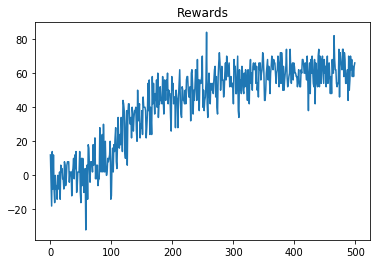

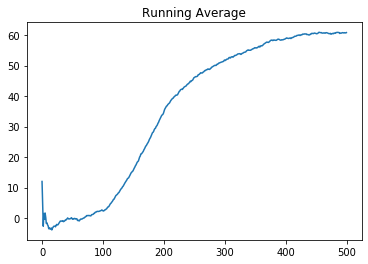



	   ACTION 0 | ACTION 1
	   -------- | --------
OBS -1.0       4.15 |    2.086
OBS -0.5      3.497 |    2.372
OBS  0.0      3.017 |     3.12
OBS  0.5      2.836 |    3.939
OBS  1.0      2.712 |     4.22



In [5]:
from experiments.utils import NullFeatureTransformer
env = gym.make('GreaterThanZero-v0')
env.__init__(max_steps_per_episode=100)
copy_period = 10
gamma = .8
start_obs = env.reset()
hidden_layer_sizes = [50, 50]
hidden_layer_opts = {'hidden_layer_sizes': hidden_layer_sizes,
                     'Z': Sigmoid(),
                     'learning_rate': 1e-5,
                     'mu': .7}
ft = NullFeatureTransformer()

D = 1
K = 2

model = NumpyDQNObsSingle(env, ft, D=D, K=K,
                          hidden_layer_opts=hidden_layer_opts,
                          gamma=gamma, start_obs=start_obs,
                          min_experiences=1)

print(model)

N = 500
totalrewards = np.zeros(N)

for n in range(N):
    eps = 1.0/(n**.1 + 1)
    totalreward = play_one(env, model, eps, gamma, copy_period)
    totalrewards[n] = totalreward
    if n % (N/10) == 0:
        ravg = running_avg(totalrewards, n)
        print('episode:', n,
              'total reward:', totalreward,
              'eps:', eps,
              'avg reward (last 10):', ravg)
    if n % (N/5) == 0:
        print(model)


print('avg reward for last 10 episodes:', totalrewards[int(-1*(N/10)):].mean())
print('total steps:', totalrewards.sum())

plt.plot(totalrewards
        )
plt.title("Rewards")
plt.show()

plot_running_avg(totalrewards)

print(model)

# NotXOR-v0


Obs.    Action 0
------  -----------------------
0,0     [0.4236301  2.20510493]
1,1     [0.42763913 2.24609481]
0,1     [0.40420371 2.22646715]
1,0     [0.45145773 2.22875625]

episode: 0 total reward: -6 eps: 1.0 avg reward (last 10): -6.0

Obs.    Action 0
------  -----------------------
0,0     [0.87531175 1.04748535]
1,1     [0.88320005 1.07682622]
0,1     [0.85743442 1.06056132]
1,0     [0.90539375 1.06669415]

episode: 50 total reward: 8 eps: 0.45549746548537273 avg reward (last 10): 2.0784313725490198
episode: 100 total reward: 6 eps: 0.3973156987429393 avg reward (last 10): 1.2277227722772277

Obs.    Action 0
------  -----------------------
0,0     [0.58400431 0.65985958]
1,1     [0.58635718 0.66882561]
0,1     [0.54530862 0.66258024]
1,0     [0.65041749 0.66671027]

episode: 150 total reward: 24 eps: 0.36661025622335097 avg reward (last 10): 1.2079207920792079
episode: 200 total reward: 40 eps: 0.34622688507614907 avg reward (last 10): 12.712871287128714

Obs.    Action 0
-

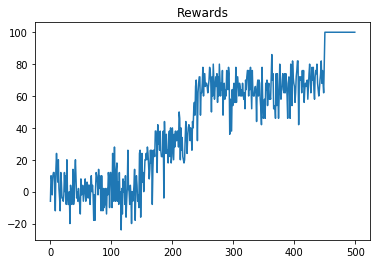

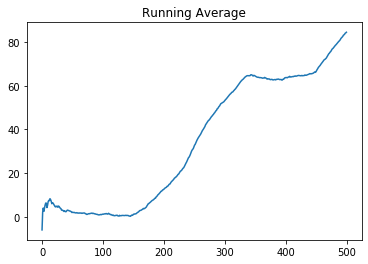


Obs.    Action 0
------  -----------------------
0,0     [2.61934323 4.58279951]
1,1     [2.61261503 4.59667749]
0,1     [4.559565   2.68416364]
1,0     [4.53101844 2.74989523]



In [14]:
from experiments.utils import NullFeatureTransformer
env = gym.make('NotXOR-v0')
env.__init__(max_steps_per_episode=100)
copy_period = 10
gamma = .8
start_obs = env.reset()
hidden_layer_sizes = [3, 3]
hidden_layer_opts = {'hidden_layer_sizes': hidden_layer_sizes,
                     'Z': Sigmoid(),
                     'learning_rate': 1e-2,
                     'mu': .7}
ft = NullFeatureTransformer()

D = 2
K = 2

model = NumpyDQNObsSingle(env, ft, D=D, K=K,
                          hidden_layer_opts=hidden_layer_opts,
                          gamma=gamma, start_obs=start_obs,
                          min_experiences=1)

print(model)

N = 500
totalrewards = np.zeros(N)

window = int(N/10)
for n in range(N):
    if n >= (N - window):
        eps = 0
    else:
        eps = 1.0/(n+1)**.2
    totalreward = play_one(env, model, eps, gamma, copy_period)
    totalrewards[n] = totalreward
    if n % window == 0:
        ravg = running_avg(totalrewards, n)
        print('episode:', n,
              'total reward:', totalreward,
              'eps:', eps,
              'avg reward (last 10):', ravg)
        print(model)


print('avg reward for last 10 episodes:', totalrewards[int(-1*(N/10)):].mean())
print('total steps:', totalrewards.sum())

plt.plot(totalrewards
        )
plt.title("Rewards")
plt.show()

plot_running_avg(totalrewards)

print(model)

# Cartpole-v0 + `NumpyDQNObsSingle`

## Solved using RBF Kernel to transform feature space into higher dimensions

This is sort of cheating since the goal of DQNs is to do the feature transformation for ou. Although I guess we can consider this as similar to the 3 convolutional layers that are in the Atari DQNs.

In [309]:
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler

class CartpoleFeatureTransformer:

    def __init__(self, env, n_components=500):
        """Fits a union of RBFSamplers on a sample set of observations.
        Pseudocode
        ----------
        Sample observation space.
        Fit a standard scaler instance to the observed examples.
        Create a representation of the state using RBF kernels (rbf samplers)
            with different variances to cover different parts of the space.
        Transform the observation examples first with the standard scaler, then
            with the union of rbf samplers.
        Store the standard scaler, rbf featurizer, and the feature example
            dimensions as attributes.
        """
        self.env = env
        self.scaler = None
        self.featurizer = None
        # obs_samples = [env.observation_space.sample() for x in range(10000)]
        obs_samples = np.random.random(( 20000, 4))*2 - 1
        scaler = StandardScaler()
        obs_samples_t = scaler.fit_transform(obs_samples)
        featurizer = FeatureUnion([
            ('rbf1', RBFSampler(gamma=5.0, n_components=n_components)),
            ('rbf5', RBFSampler(gamma=2.0, n_components=n_components)),
            ('rbf3', RBFSampler(gamma=1.0, n_components=n_components)),
            ('rbf4', RBFSampler(gamma=0.5, n_components=n_components)),
        ])
        obs_samples_t = featurizer.fit_transform(obs_samples_t)
        self.scaler = scaler
        self.featurizer = featurizer
        self.dimensions = obs_samples_t.shape[1]

    def transform(self, observations):
        scaled = self.scaler.transform(observations)
        return self.featurizer.transform(scaled)

/Users/jblandin/miniconda3/envs/research/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
too few experiences 1
too few experiences 2
too few experiences 3
too few experiences 4
episode: 0 total reward: 20.0 eps: 1.0 avg reward (last 10): 20.0
episode: 10 total reward: 8.0 eps: 0.30151134457776363 avg reward (last 10): 14.909090909090908
episode: 20 total reward: 12.0 eps: 0.2182178902359924 avg reward (last 10): 12.666666666666666
episode: 30 total reward: 10.0 eps: 0.1796053020267749 avg reward (last 10): 11.64516129032258
episode: 40 total reward: 15.0 eps: 0.15617376188860607 avg reward (last 10): 13.024390243902438
episode: 50 total reward: 31.0 eps: 0.14002800840280097 avg reward (last 10): 15.901960784313726
episode: 60 total reward: 36.0 eps: 0.12803687993289598 avg reward (last 10): 18.524590163934427
episode: 70 total reward: 36.0 eps: 0.11867816581938533 avg reward (last 10): 21.211267605633804
episode: 80 total reward: 30.0 eps: 0.1111111111111111 avg reward (last 

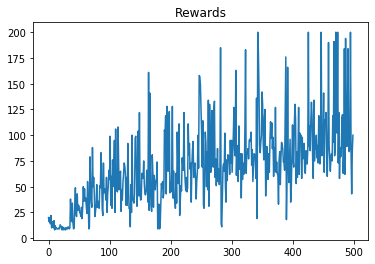

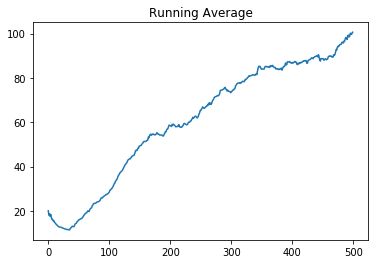

In [348]:
env = gym.make('CartPole-v0')
copy_period = 10
gamma = 0.8
start_obs = env.reset()
# D = len(env.observation_space.sample())
# Set D to shape of output of feature_transformer.transform()
D = 2000
K = env.action_space.n
hidden_layer_sizes = [1]
hidden_layer_opts = {'hidden_layer_sizes': hidden_layer_sizes,
                     'Z': ReLU(),
                     'learning_rate': 1e-2,
                     'mu': .5}
feature_transformer = CartpoleFeatureTransformer(env)
model = NumpyDQNObsSingle(env, feature_transformer, D=D, K=K,
                          hidden_layer_opts=hidden_layer_opts,
                          gamma=gamma, start_obs=start_obs)

N = 500
totalrewards = np.zeros(N)

for n in range(N):
    eps = 1.0/np.sqrt(n+1)
    totalreward = play_one(env, model, eps, gamma, copy_period)
    totalrewards[n] = totalreward
    if n % 10 == 0:
        ravg = running_avg(totalrewards, n)
        print('episode:', n,
              'total reward:', totalreward,
              'eps:', eps,
              'avg reward (last 10):', ravg)
        if ravg > 150:
            break


totalrewards = totalrewards[np.where(totalrewards > 0)]
print('avg reward for last 10 episodes:', totalrewards[-10:].mean())
print('total steps:', totalrewards.sum())

plt.plot(totalrewards)
plt.title("Rewards")
plt.show()

plot_running_avg(totalrewards)

## Without a feature transformer

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
too few experiences 1
too few experiences 2
too few experiences 3
too few experiences 4
episode: 0 total reward: 36.0 eps: 1.0 avg reward (last 10): 36.0
episode: 10 total reward: 20.0 eps: 0.30151134457776363 avg reward (last 10): 16.0
episode: 20 total reward: 19.0 eps: 0.2182178902359924 avg reward (last 10): 17.428571428571427
episode: 30 total reward: 23.0 eps: 0.1796053020267749 avg reward (last 10): 19.903225806451612
episode: 40 total reward: 17.0 eps: 0.15617376188860607 avg reward (last 10): 20.48780487804878
episode: 50 total reward: 26.0 eps: 0.14002800840280097 avg reward (last 10): 23.80392156862745
episode: 60 total reward: 23.0 eps: 0.12803687993289598 avg reward (last 10): 27.0
episode: 70 total reward: 94.0 eps: 0.11867816581938533 avg reward (last 10): 29.450704225352112
episode: 80 total reward: 35.0 eps: 0.1111111111111111 avg reward (last 10): 35.02469135802469
episo

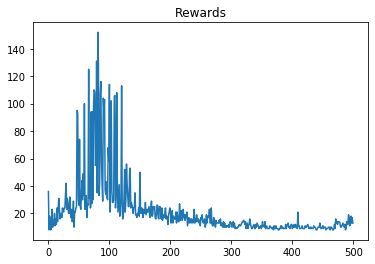

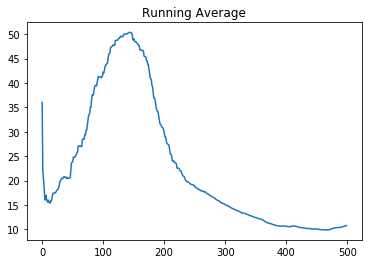

In [9]:
from experiments.utils import NullFeatureTransformer

env = gym.make('CartPole-v0')
copy_period = 10
gamma = 0.8
start_obs = env.reset()
D = len(env.observation_space.sample())
K = env.action_space.n
hidden_layer_sizes = [2000, 10]
hidden_layer_opts = {'hidden_layer_sizes': hidden_layer_sizes,
                     'Z': ReLU(),
                     'learning_rate': 5e-6,
                     'mu': .5}
feature_transformer = NullFeatureTransformer()
model = NumpyDQNObsSingle(env, feature_transformer, D=D, K=K,
                          hidden_layer_opts=hidden_layer_opts,
                          gamma=gamma, start_obs=start_obs)

N = 500
totalrewards = np.zeros(N)

for n in range(N):
    eps = 1.0/np.sqrt(n+1)
    totalreward = play_one(env, model, eps, gamma, copy_period)
    totalrewards[n] = totalreward
    if n % 10 == 0:
        ravg = running_avg(totalrewards, n)
        print('episode:', n,
              'total reward:', totalreward,
              'eps:', eps,
              'avg reward (last 10):', ravg)
        if ravg > 150:
            break

print('avg reward for last 10 episodes:', totalrewards[-10:].mean())
print('total steps:', totalrewards.sum())

plt.plot(totalrewards)
plt.title("Rewards")
plt.show()

plot_running_avg(totalrewards)